The goal of this notebook is to **analyze the origin-destination data from the NYC Suwbays.** In particular, I am interested in the different classifications of subway stations based on ridership by time of day and week. For instance, stations near lower manhattan will have much different characteristics than stations in south brooklyn (e.g.: Whitehall St (R) vs. 95th st in Bay Ridge (R)).  

# Imports

In [2]:
import pandas as pd 
import os
import calendar 
import datetime
from clustergram import Clustergram
import seaborn
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import numpy as np
import geopandas as gpd
from geodatasets import get_path


## Functions

In [3]:
def generate_day_number(dataframe: pd.DataFrame, day_of_week_colum='Day of Week'):
    day_mapping = list(calendar.day_name)
    day_number_list = []
    for value in dataframe[day_of_week_colum]:
        new_value = day_mapping.index(value)
        day_number_list.append(new_value)
    dataframe['day_number'] = day_number_list
    return dataframe

def determine_train_time_intervals(arrival_time, day_of_week: str):
    arrival_time = datetime.time(arrival_time)
    train_time_interval = None
    if datetime.time(0, 0) <= arrival_time < datetime.time(6, 30):
        train_time_interval = 'Late Night'
    elif day_of_week in ['Saturday', 'Sunday']:
        train_time_interval = 'Weekend'
    elif datetime.time(6) <= arrival_time < datetime.time(9):
        train_time_interval = 'Rush Hour AM'
    elif datetime.time(9) <= arrival_time < datetime.time(15):
        train_time_interval = 'Midday'
    elif datetime.time(15) <= arrival_time < datetime.time(20, 0):
        train_time_interval = 'Rush Hour PM'
    elif datetime.time(20, 0) <= arrival_time <= datetime.time(23, 59):
        train_time_interval = 'Evening'
    return train_time_interval

def get_total_average_ridership_by_station(dataframe:pd. DataFrame, type_of_trip: str):
    total_ridership_values = []
    for idx in range(len(dataframe)):
        station = dataframe['Station Complex Name'][idx]
        total_ridership = dataframe[dataframe['Station Complex Name']
                                    ==station][f'Estimated Average Ridership - {type_of_trip}'].sum()
        total_ridership_values.append(total_ridership)
    dataframe[f'Estimated Average Ridership - {type_of_trip} - Total'] = total_ridership_values
    return dataframe

def find_ratio_diff_to_median(df: pd.DataFrame, destination_origin_str: str):
    median_o_d_ratios = df.groupby('time_interval')[f'{destination_origin_str} Interval Ridership Ratio'].median()
    o_d_ratio_diff_list = []
    for idx in range(len(df)):
        ratio_diff = round(float(df[f'{destination_origin_str} Interval Ridership Ratio'][idx] - median_o_d_ratios[df['time_interval'][idx]]), 2)
        o_d_ratio_diff_list.append(ratio_diff)
    df[f'{destination_origin_str}_ratio_diff'] = o_d_ratio_diff_list
    return df

## Data Imports

In [4]:
origin_df = pd.read_csv("./transformed_data/origin_data_transformed.csv", index_col=0)
destination_df = pd.read_csv("./transformed_data/destination_data_transformed.csv", index_col=0)
station_names_df = pd.read_csv("./transformed_data/station_names_transformed.csv", index_col=0)

### Transformations

In [5]:
# Adding the station names
origin_df = origin_df.merge(station_names_df[['Station Complex ID', 'Station Complex Name']]
                     , left_on='Origin Station Complex ID', right_on='Station Complex ID')
origin_df = origin_df.drop(columns=['Station Complex ID'])
destination_df = destination_df.merge(station_names_df[['Station Complex ID', 'Station Complex Name']]
                     , left_on='Destination Station Complex ID', right_on='Station Complex ID')
destination_df = destination_df.drop(columns=['Station Complex ID'])

In [6]:
# # making day names to day numbers 
# origin_df = generate_day_number(origin_df)
# destination_df = generate_day_number(destination_df)

In [7]:
# interval names 
interval_list_origin = [determine_train_time_intervals(origin_df['Hour of Day'][idx], 
                                                origin_df['Day of Week'][idx]) 
                                                for idx in range(len(origin_df))]
origin_df['time_interval'] = interval_list_origin
interval_list_destination = [determine_train_time_intervals(destination_df['Hour of Day'][idx], 
                                                destination_df['Day of Week'][idx]) 
                                                for idx in range(len(destination_df))]
destination_df['time_interval'] = interval_list_destination

In [8]:
# group by interval 
origin_df_interval = origin_df.groupby(['Station Complex Name'
                                        , 'time_interval'])['Estimated Average Ridership'].sum().reset_index()
origin_df_interval.columns = ['Station Complex Name', 'time_interval', 'Estimated Average Ridership - Origin']
destination_df_interval = destination_df.groupby(['Station Complex Name'
                                        , 'time_interval'])['Estimated Average Ridership'].sum().reset_index()
destination_df_interval.columns = ['Station Complex Name', 'time_interval', 'Estimated Average Ridership - Destination']

In [9]:
# Jefferson St 
# destination_df_interval[destination_df_interval['Station Complex Name'].str.contains("Jefferson")]
# origin_df_interval[origin_df_interval['Station Complex Name'].str.contains("Jefferson")]

In [10]:
# add total ridership to df for each station 
origin_df_interval = get_total_average_ridership_by_station(origin_df_interval, 'Origin')
origin_df_interval['Origin Interval Ridership Ratio'] = round(origin_df_interval['Estimated Average Ridership - Origin']
                                                              / origin_df_interval['Estimated Average Ridership - Origin - Total'], 2)
destination_df_interval = get_total_average_ridership_by_station(destination_df_interval, 'Destination')
destination_df_interval['Destination Interval Ridership Ratio'] = round(destination_df_interval['Estimated Average Ridership - Destination']
                                                              / destination_df_interval['Estimated Average Ridership - Destination - Total'], 2)

In [11]:
# full interval dataframe
full_interval_df = origin_df_interval.merge(destination_df_interval, on=['Station Complex Name', 'time_interval'])
full_interval_df = find_ratio_diff_to_median(full_interval_df, "Destination")
full_interval_df = find_ratio_diff_to_median(full_interval_df, "Origin")
full_interval_df.head()

,Station Complex Name,time_interval,Estimated Average Ridership - Origin,Estimated Average Ridership - Origin - Total,Origin Interval Ridership Ratio,Estimated Average Ridership - Destination,Estimated Average Ridership - Destination - Total,Destination Interval Ridership Ratio,Destination_ratio_diff,Origin_ratio_diff
0,1 Av (L),Evening,14126.571429,111844.428571,0.13,10994.857143,112912.0,0.10,0.00,0.08
1,1 Av (L),Late Night,4824.857143,111844.428571,0.04,7014.571429,112912.0,0.06,-0.01,-0.06
2,1 Av (L),Midday,24589.571429,111844.428571,0.22,22807.000000,112912.0,0.20,0.00,-0.03
3,1 Av (L),Rush Hour AM,12870.000000,111844.428571,0.12,12918.857143,112912.0,0.11,0.02,-0.07
4,1 Av (L),Rush Hour PM,34197.000000,111844.428571,0.31,36801.571429,112912.0,0.33,-0.03,0.08


In [12]:
median_destination_ratios = full_interval_df.groupby('time_interval')['Destination Interval Ridership Ratio'].median()
median_origin_ratios = full_interval_df.groupby('time_interval')['Origin Interval Ridership Ratio'].median()

### Mapping

In [13]:
path_to_file = get_path('nybb')
boros = gpd.read_file(path_to_file)
boros = boros.to_crs(epsg=3857)
boros.drop(0, inplace=True) #removing staten island

In [14]:
stations_geodataframe = gpd.GeoDataFrame(station_names_df
                                        , geometry=gpd.points_from_xy(station_names_df['Longitude']
                                                                     , station_names_df['Latitude']))
stations_geodataframe = stations_geodataframe.set_crs(epsg=4326).to_crs(epsg=3857)

# Clustering

## Ridership Ratios

### Prep

In [15]:
full_interval_df_w_clusters = full_interval_df.pivot(index='Station Complex Name', columns='time_interval'
                                , values=['Origin_ratio_diff', 'Destination_ratio_diff'])
interval_data = scale(full_interval_df_w_clusters)

### Determining number of clusters

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.093 seconds.
K=3 fitted in 0.003 seconds.
K=4 fitted in 0.007 seconds.


2    0.415055
3    0.386945
4    0.222126
Name: silhouette_score, dtype: float64

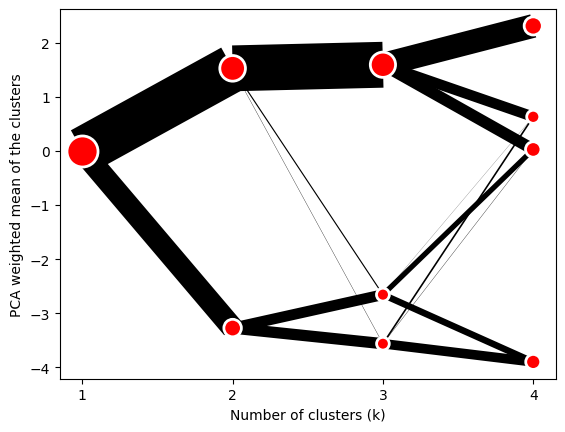

In [16]:
# 3 clusters is the way to go
cgram = Clustergram(range(1, 5))
cgram.fit(interval_data)
cgram.plot()
cgram.silhouette_score()

### Clustering 

In [17]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(interval_data)
full_interval_df_w_clusters['clusters'] = kmeans.labels_.astype(str)
full_interval_df_w_clusters['clusters'] = full_interval_df_w_clusters['clusters'].replace({'0': 'residential'
                                                                                           , '1': 'destination'})
                                                                                                   
# kmeans.cluster_centers_

In [18]:
# no diff in weekend, bigg diff in rush hour pm o v. d
# cluster 0 is rush hour Rush Hour AM/late night origin, Rush Hour Destination
# cluster 1 is evening/rush hour PM origin, Rush Hour AM destination
round(full_interval_df_w_clusters.groupby('clusters').median(),2)
# 0 is residential/attraction area
# 1 is job center

Origin_ratio_diff                                              \
time_interval           Evening Late Night Midday Rush Hour AM Rush Hour PM   
clusters                                                                      
destination                0.04      -0.06  -0.03        -0.10         0.13   
residential               -0.01       0.02   0.01         0.02        -0.03   

                      Destination_ratio_diff                                 \
time_interval Weekend                Evening Late Night Midday Rush Hour AM   
clusters                                                                      
destination      0.02                  -0.04        0.0   0.06         0.07   
residential     -0.01                   0.01        0.0  -0.01        -0.01   

                                    
time_interval Rush Hour PM Weekend  
clusters                            
destination          -0.10    0.02  
residential           0.03    0.00

In [19]:
# full_interval_df_w_clusters[full_interval_df_w_clusters['clusters']==0]
# full_interval_df_w_clusters[full_interval_df_w_clusters['clusters']==1].iloc[0:15]

## Cluster based on total ridership counts 

In [20]:
full_interval_ridership_df_w_clusters = full_interval_df.drop(columns=['Estimated Average Ridership - Origin - Total'
                                                   , 'Origin Interval Ridership Ratio'
                                                   , 'Estimated Average Ridership - Destination - Total'
                                                   , 'Destination Interval Ridership Ratio'])

In [21]:
full_interval_ridership_df_w_clusters = full_interval_ridership_df_w_clusters.pivot(index='Station Complex Name', columns='time_interval'
                       , values=['Estimated Average Ridership - Origin', 'Estimated Average Ridership - Destination'])
interval_ridership_data = scale(full_interval_ridership_df_w_clusters)

### Number of Clusters

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.007 seconds.
K=3 fitted in 0.003 seconds.
K=4 fitted in 0.002 seconds.


2    0.851074
3    0.641403
4    0.643331
Name: silhouette_score, dtype: float64

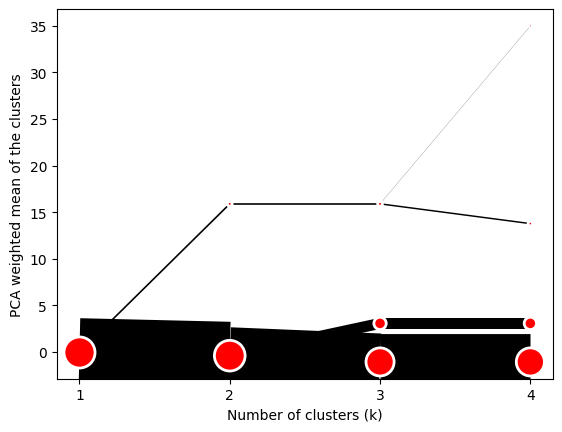

In [22]:
# 3 clusters
cgram2 = Clustergram(range(1, 5))
cgram2.fit(interval_ridership_data)
cgram2.plot()
cgram2.silhouette_score()

### Clustering

In [23]:
kmeans2 = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(interval_ridership_data)
full_interval_ridership_df_w_clusters['clusters'] = kmeans2.labels_.astype(str)
full_interval_ridership_df_w_clusters['clusters'] = full_interval_ridership_df_w_clusters['clusters'].replace({'0': 'low ridership'
                                                                                                                     ,'1': 'high ridership'})
# kmeans.cluster_centers_

In [24]:
round(full_interval_ridership_df_w_clusters.groupby('clusters').median())

Estimated Average Ridership - Origin                      \
time_interval                               Evening Late Night   Midday   
clusters                                                                  
high ridership                              25839.0    10438.0  48485.0   
low ridership                                1307.0     2365.0   6804.0   

                                                   \
time_interval  Rush Hour AM Rush Hour PM  Weekend   
clusters                                            
high ridership      20346.0      98326.0  46294.0   
low ridership        4784.0       5855.0   4326.0   

               Estimated Average Ridership - Destination                      \
time_interval                                    Evening Late Night   Midday   
clusters                                                                       
high ridership                                   14670.0    18257.0  67651.0   
low ridership                                     2744.0     1840.0   4989.0   

                                                   
time_interval  Rush Hour AM Rush Hour PM  Weekend  
clusters                                           
high ridership      42360.0      61021.0  48788.0  
low ridership        2248.0       9657.0   4311.0

## Union of two clusters

In [25]:
cluster_combo_df = full_interval_df_w_clusters.reset_index()[[('Station Complex Name','')
                                                              ,('clusters','') ]].merge(
                    full_interval_ridership_df_w_clusters.reset_index()[[('Station Complex Name','')
                                                                        ,('clusters','') ]]
                    , on='Station Complex Name'
)   
cluster_combo_df = cluster_combo_df.drop(columns=['Station Complex Name'])
cluster_combo_df.columns = ['Station Complex Name', 'ridership_ratio_clusters', 'total_ridership_clusters'] 
cluster_combo_df['combo_cluster'] = [str(cluster_combo_df['ridership_ratio_clusters'][idx]) + '-' + 
                                     cluster_combo_df['total_ridership_clusters'][idx]
                                    for idx in range(len(cluster_combo_df))]  

/var/folders/8x/kvnrx4697fv2091hzl57dkbr0000gn/T/ipykernel_19284/369055506.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ,('clusters','') ]].merge(


In [26]:
# Most for each ratio cluster:
#  1- high riderhip, 0-low
cluster_combo_df['combo_cluster'].value_counts(normalize=True, ascending=True)*100

combo_cluster
residential-high ridership     0.471698
destination-high ridership     4.952830
destination-low ridership     26.886792
residential-low ridership     67.688679
Name: proportion, dtype: float64

In [27]:
# 0 is residential/attraction area
# 1 is job center
cluster_combo_df[cluster_combo_df['combo_cluster']=='1-low ridership']

,Station Complex Name,ridership_ratio_clusters,total_ridership_clusters,combo_cluster


In [28]:
# full_interval_df_w_clusters.reset_index()[full_interval_df_w_clusters.reset_index()['Station Complex Name'].str.contains("74-Broadway")]
# full_interval_df_w_clusters.reset_index()[full_interval_df_w_clusters.reset_index()['Station Complex Name'].isin(
#     cluster_combo_df[cluster_combo_df['combo_cluster']=='1-low ridership']['Station Complex Name'])]


# Mapping the Clusters

In [29]:
stations_geodataframe_w_clusters = stations_geodataframe.merge(cluster_combo_df)

In [30]:
stations_geodataframe_w_clusters.head(2)

,Station Complex ID,Station Complex Name,Latitude,Longitude,geometry,ridership_ratio_clusters,total_ridership_clusters,combo_cluster
0,340,"Grand Army Plaza (2,3)",40.675235,-73.971046,POINT (-8234419.174 4964556.275),residential,low ridership,residential-low ridership
1,320,23 St (1),40.744081,-73.995657,POINT (-8237158.858 4974666.639),destination,low ridership,destination-low ridership


<Axes: title={'center': 'Function Type and Ridership Level of NYC Subway Complexes'}>

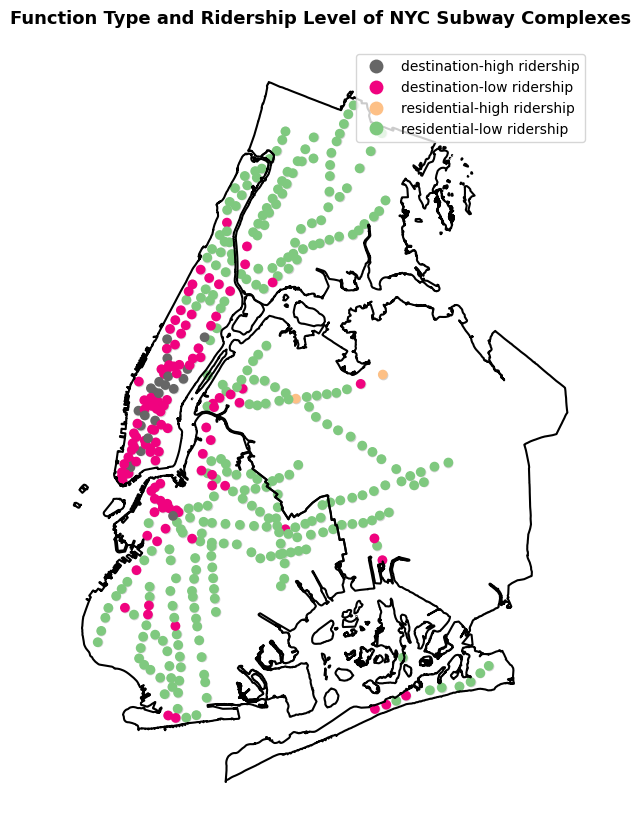

In [31]:
# plotting clusters
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.set_title("Function Type and Ridership Level of NYC Subway Complexes"
             , color='black', fontsize=13, weight='bold')
boros.boundary.plot(ax=ax, color="black")
stations_geodataframe_w_clusters.plot(color='lightgray', ax=ax)
# stations
stations_geodataframe_w_clusters.plot(column='combo_cluster', ax=ax
                                      , legend=True, cmap='Accent_r'
                                      , legend_kwds={'loc': 'upper right'})

# Saving Data

In [35]:
# Saving all Data 
if not os.path.exists('saved_data'):
    os.makedirs('saved_data')

In [37]:
# just the stations and their clusters
cluster_combo_df.to_csv("saved_data/clustered_stations.csv")

In [41]:
# destination type values and clusters
full_interval_df_w_clusters.to_csv("saved_data/clustered_stations_by_destination_type.csv")

In [42]:
# ridership values and clusters
full_interval_ridership_df_w_clusters.to_csv("saved_data/clustered_stations_by_ridership.csv")